In [1]:
import cv2
import os

import numpy as np

import face_recognition

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm

In [2]:
tqdm.pandas()

In [5]:
query_subjs = pd.read_csv('../app/data/query_imgs_lfw_processed.csv')
query_subjs.head()

,img_name,gcp_path,person_name,img_path
0,Zico_0003.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Zico,/home/guilherme/projects/parai/app/data/images...
1,Wu_Yi_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Wu_Yi,/home/guilherme/projects/parai/app/data/images...
2,Juanes_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Juanes,/home/guilherme/projects/parai/app/data/images...
3,Al_Gore_0006.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...
4,Al_Gore_0005.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...


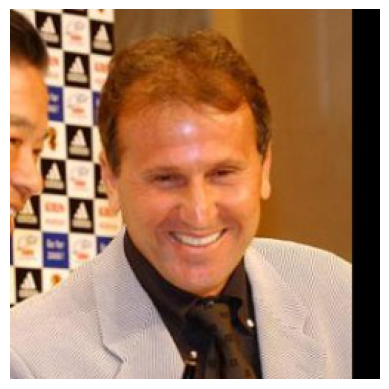

In [9]:
def show_img(img_path):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_img(query_subjs['img_path'].iloc[0])    

In [4]:
def load_templates_dataset(templates_dir_path):
    N_SUBJS_TO_LOAD = 100000

    templates_paths = os.listdir(templates_dir_path)
    known_face_encodings = [np.load(os.path.join(templates_dir_path, template_path)) for template_path in templates_paths]
    known_face_names = [template_path.split('.')[0] for template_path in templates_paths]

    final_encodings, final_names = [], []
    for enc, name in zip(known_face_encodings, known_face_names):
        if 'guilherme' in name:
            final_encodings.append(enc)
            final_names.append(name)
    
    final_encodings = final_encodings + known_face_encodings[:N_SUBJS_TO_LOAD]
    final_names = final_names + known_face_names[:N_SUBJS_TO_LOAD]

    known_face_encodings = final_encodings
    known_face_names = final_names

    print(f'Total known face encodings: {len(known_face_encodings)}')
    print(f'Total known face names: {len(known_face_names)}')
    print(f'Known face names: {known_face_names[:10]}')
    print('----------')

    return known_face_encodings, known_face_names


known_face_encodings, known_face_names = load_templates_dataset('../app/data/templates/fr_templates/')


Total known face encodings: 1564
Total known face names: 1564
Known face names: ['guilherme_4', 'guilherme_3', 'guilherme_1', 'guilherme_2', 'Edward_Kennedy_0003', 'Hosni_Mubarak_0001', 'Abel_Pacheco_0002', 'Iban_Mayo_0002', 'Demetrius_Ferraciu_0001', 'Bo_Pelini_0001']
----------


In [5]:
def identify(img_path, top_n=5):
    rgb_frame = face_recognition.load_image_file(img_path)
    
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    final_face_names, final_face_dists = [],[]
    for face_encoding in face_encodings:
        # See if the face is a match for the known face(s)
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=0.7)  # 0.54
        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        #name = "Unknown"

        #print(f'Matches: {matches[:10]}')
        #print(f'Face Distances: {face_distances[:10]}')
        
        # If a match was found in known_face_encodings, just use the first one.
        # if True in matches:
        #     first_match_index = matches.index(True)
        #     name = known_face_names[first_match_index]
            
        # Or instead, use the known face with the smallest distance to the new face
        # else:
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = known_face_names[best_match_index]
            face_dist = face_distances[best_match_index]

            final_face_names.append(name)
            final_face_dists.append(face_dist)
    
    return final_face_names[:top_n], final_face_dists[:top_n]

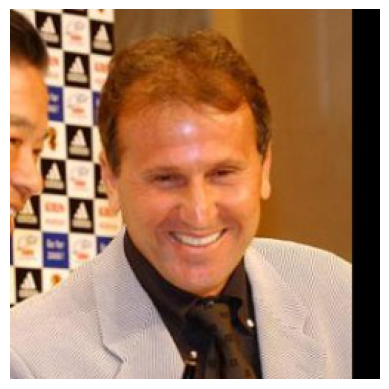

(['Zico_0001'], [0.35908478097103325])


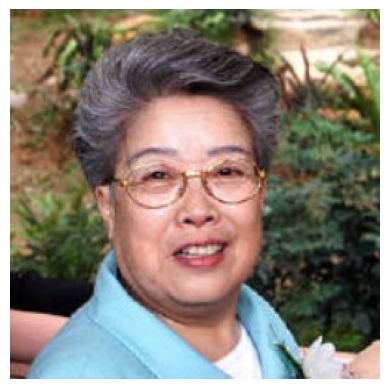

(['Wu_Yi_0002'], [0.3900499058801624])


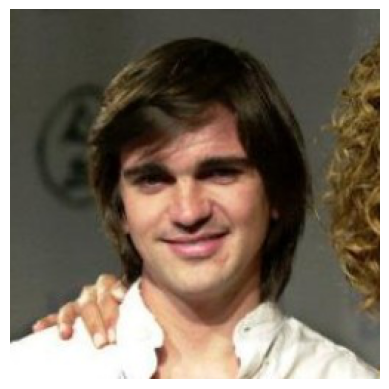

(['Juanes_0003'], [0.3498539737157639])


In [11]:
img_1 = query_subjs['img_path'].iloc[0]
img_2 = query_subjs['img_path'].iloc[1]
img_3 = query_subjs['img_path'].iloc[2]

show_img(img_1)
print(identify(img_1))

show_img(img_2)
print(identify(img_2))

show_img(img_3)
print(identify(img_3))

In [16]:

query_subjs['identify_results'] = query_subjs.progress_apply(lambda row: identify(row['img_path']), axis=1)
query_subjs.head()


100%|██████████| 7484/7484 [03:51<00:00, 32.35it/s]


,img_name,gcp_path,person_name,img_path,identify_results
0,Zico_0003.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Zico,/home/guilherme/projects/parai/app/data/images...,"([Zico_0001], [0.35908478097103325])"
1,Wu_Yi_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Wu_Yi,/home/guilherme/projects/parai/app/data/images...,"([Wu_Yi_0002], [0.3900499058801624])"
2,Juanes_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Juanes,/home/guilherme/projects/parai/app/data/images...,"([Juanes_0003], [0.3498539737157639])"
3,Al_Gore_0006.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...,"([Dan_Morales_0003], [0.5689061296700253])"
4,Al_Gore_0005.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...,"([Al_Gore_0008], [0.565260519749274])"


In [17]:
query_subjs['top_1_name'] = query_subjs['identify_results'].apply(lambda x: x[0][0] if len(x[0]) > 0 else None)
query_subjs['top_1_dist'] = query_subjs['identify_results'].apply(lambda x: x[1][0] if len(x[1]) > 0 else None)

query_subjs.head()

,img_name,gcp_path,person_name,img_path,identify_results,top_1_name,top_1_dist
0,Zico_0003.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Zico,/home/guilherme/projects/parai/app/data/images...,"([Zico_0001], [0.35908478097103325])",Zico_0001,0.359085
1,Wu_Yi_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Wu_Yi,/home/guilherme/projects/parai/app/data/images...,"([Wu_Yi_0002], [0.3900499058801624])",Wu_Yi_0002,0.390050
2,Juanes_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Juanes,/home/guilherme/projects/parai/app/data/images...,"([Juanes_0003], [0.3498539737157639])",Juanes_0003,0.349854
3,Al_Gore_0006.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...,"([Dan_Morales_0003], [0.5689061296700253])",Dan_Morales_0003,0.568906
4,Al_Gore_0005.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...,"([Al_Gore_0008], [0.565260519749274])",Al_Gore_0008,0.565261


In [18]:
query_subjs.to_csv('../app/data/query_imgs_lfw_identified.csv', index=False)

In [23]:
query_subjs['subj_id'] = query_subjs['img_name'].apply(lambda x: x[:-9])
query_subjs['pred_subj_id'] = query_subjs['top_1_name'].apply(lambda x: x[:-5] if x is not None else None)
query_subjs.head()

,img_name,gcp_path,person_name,img_path,identify_results,top_1_name,top_1_dist,true_match,subj_id,pred_subj_id
0,Zico_0003.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Zico,/home/guilherme/projects/parai/app/data/images...,"([Zico_0001], [0.35908478097103325])",Zico_0001,0.359085,False,Zico,Zico
1,Wu_Yi_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Wu_Yi,/home/guilherme/projects/parai/app/data/images...,"([Wu_Yi_0002], [0.3900499058801624])",Wu_Yi_0002,0.390050,False,Wu_Yi,Wu_Yi
2,Juanes_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Juanes,/home/guilherme/projects/parai/app/data/images...,"([Juanes_0003], [0.3498539737157639])",Juanes_0003,0.349854,False,Juanes,Juanes
3,Al_Gore_0006.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...,"([Dan_Morales_0003], [0.5689061296700253])",Dan_Morales_0003,0.568906,False,Al_Gore,Dan_Morales
4,Al_Gore_0005.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...,"([Al_Gore_0008], [0.565260519749274])",Al_Gore_0008,0.565261,False,Al_Gore,Al_Gore


In [24]:
query_subjs['true_match'] = query_subjs['pred_subj_id'] == query_subjs['subj_id']
query_subjs.head()

,img_name,gcp_path,person_name,img_path,identify_results,top_1_name,top_1_dist,true_match,subj_id,pred_subj_id
0,Zico_0003.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Zico,/home/guilherme/projects/parai/app/data/images...,"([Zico_0001], [0.35908478097103325])",Zico_0001,0.359085,True,Zico,Zico
1,Wu_Yi_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Wu_Yi,/home/guilherme/projects/parai/app/data/images...,"([Wu_Yi_0002], [0.3900499058801624])",Wu_Yi_0002,0.390050,True,Wu_Yi,Wu_Yi
2,Juanes_0001.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Juanes,/home/guilherme/projects/parai/app/data/images...,"([Juanes_0003], [0.3498539737157639])",Juanes_0003,0.349854,True,Juanes,Juanes
3,Al_Gore_0006.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...,"([Dan_Morales_0003], [0.5689061296700253])",Dan_Morales_0003,0.568906,False,Al_Gore,Dan_Morales
4,Al_Gore_0005.jpg,gs://original-datasets-pesquisa/face/LFW/lfw/l...,Al_Gore,/home/guilherme/projects/parai/app/data/images...,"([Al_Gore_0008], [0.565260519749274])",Al_Gore_0008,0.565261,True,Al_Gore,Al_Gore


In [26]:
aux_df = query_subjs.copy(deep=True)

aux_df.dropna(subset=['top_1_name'], inplace=True)

acc_score = aux_df['true_match'].sum() / aux_df.shape[0]
acc_score

0.8765250033516557